# U(1) Symmetric Monitored Random Circuits
Creates an instance of a U1 MRC with specified qubit number, depth, measurement locations, and circuit parameters in qiskit

In [1]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt

In [2]:
## Global parameters
PARAMS_PER_GATE = 6 # number parameters for general U1 2q gate

## Form of 2-qubit gates:
taken from https://arxiv.org/pdf/quant-ph/0308006.pdf

general U(1) entangling operation, with $\alpha=\beta$:

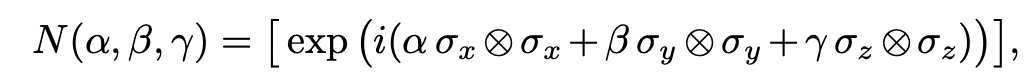

circuit compilation of above with 3 CNOTS

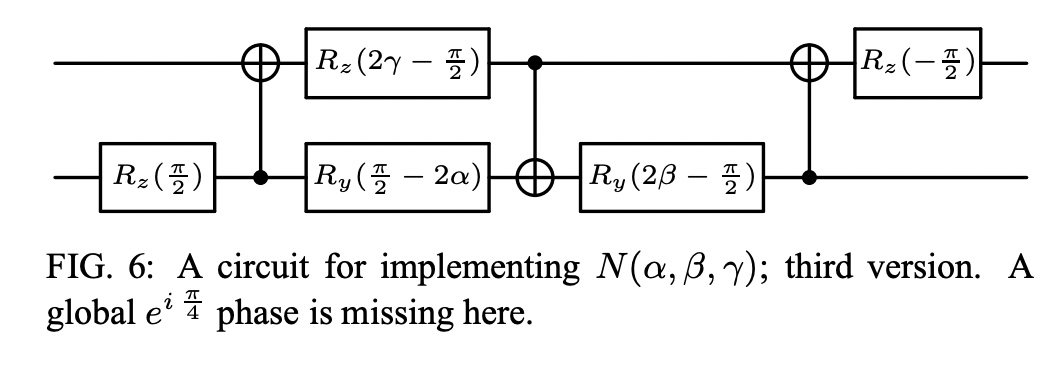


## Gate and Circuit Creation Functions

In [3]:
import random
# Function to create 2q gate
def u1gate(circ,gate_params,q1,q2,debug=False):
    """
    inputs: 
        circ = qiskit circuit containing q1,q2
        gate_parmas = np.array of PARAMS_PER_GATE=6 floats
        q1,q2 qiskit qubits
    returns:
        nothing, adds u1 gate directly to circ
    """
    if debug: # for debugging circuits, just put in czs for ease of visualizing
        circ.cz(q1,q2) 
    else:
        # arbitrary z rotations
        circ.rz(gate_params[0],q1)
        circ.rz(gate_params[1],q2)

        # XX+YY,ZZ rotations
        circ.rz(np.pi/2,q2)
        circ.cnot(q2,q1)
        circ.rz(2*gate_params[2]-np.pi/2,q1)
        circ.ry(np.pi/2-2*gate_params[3],q2)
        circ.cnot(q1,q2)
        circ.ry(2*gate_params[3]-np.pi/2,q2)
        circ.cnot(q2,q1)
        circ.rz(-np.pi/2,q1)

        # arbitrary z rotations    
        circ.rz(gate_params[4],q1)
        circ.rz(gate_params[5],q2)

# state preparation: returns evolved state by unitaries, when initial state is product state of fixed charge
def state_preparation(L,depth,params,initial_charge):
    charge_locations = random.sample(range(L), initial_charge) # randomly select locations of charges
    qreg = qk.QuantumRegister(L,'q')
    # add the registers to the circuit
    circ = qk.QuantumCircuit(qreg)
    for i in range(initial_charge):
        circ.x([charge_locations[i]])
    # create the circuit layer-by-layer
    for i in range(depth):
        # gates
        if i%2 == 0: # even layer
            for j in range(L//2):
                u1gate(circ,params[i][j],qreg[2*j],qreg[2*j+1])
        else: # odd layer
            for j in range(1,L//2):
                u1gate(circ,params[i][j-1],qreg[2*j-1],qreg[2*j])    
    return qreg, circ                      

# Function to generate a random circuit
def generate_u1mrc(L,depth,m_locs,params,initial_charge,debug=False):
    """
    inputs:
        - L, int, system size
        - depth, int, number of circuit layers (one layer = even or odd bond gates, not both)
        - m_locs, np.array of bools, m_locs[i,j]=1 => add measurement after layer i and on qubit j
        - init_state, np.array with all qubit locations that have state 1 (the rest being in state 0)
        - params, nested list of circuit parameters, 
            params[i][j] is an np.array of PARAMS_PER_GATE=6 floats
            specifying the circuit parameters for the jth gate in layer i (counting from the left of the circuit)
        - debug, bool, if True replaces u1 gates with cz gates and adds barriers so that you can visualize more easily
    outputs:
        - qiskit circuit of appropriate
    """
    qreg, circ = state_preparation(L,depth,params,initial_charge)
    creg_list = [qk.ClassicalRegister(L,'c'+str(j)) for j in range(depth)] # for measurement outcomes

    for reg in creg_list:
        circ.add_register(reg)
    # create the circuit layer-by-layer
    for i in range(depth):
        # gates
        if i%2 == 0: # even layer
            for j in range(L//2):
                u1gate(circ,params[i][j],qreg[2*j],qreg[2*j+1],debug=debug)
        else: # odd layer
            for j in range(1,L//2):
                u1gate(circ,params[i][j-1],qreg[2*j-1],qreg[2*j],debug=debug)
        if i<depth-1:        
            for j in range(L):
                if m_locs[i,j]:
                    circ.measure(j,creg_list[i][j])       

        if debug: circ.barrier()

    # final measurements
    circ.measure(qreg,creg_list[i])
    
    return qreg, creg_list, circ

## Create an instance

In [419]:
L = 14
depth = L
p = 0.2 # measurement probability
circuit_iter = 1

# Random parts
# measurement locations
# entry [i,j] is layer i, qubit j
# 1 denotes measurement, 0 = no measurement
m_locs = np.random.binomial(1,p,L*(depth-1)).reshape((depth-1,L))

# generate random circuit parameters
# each layer has L//2
#params = 4*np.pi*np.random.rand(depth,L//2,PARAMS_PER_GATE)
param_list = [[4*np.pi*np.random.rand(PARAMS_PER_GATE) 
               for j in range(L//2-(i%2))] # there are either L//2 or L//2-1 gates for even/odd layers resp.
             for i in range(depth)]

In [423]:
s = 0
# initial charge
initial_charge = int(L/2)+s

# Create a circuit instance
# Draw circuit
print('Remember to set debug=FALSE to generate actual circuits...')
qreg,creg_list,circ = generate_u1mrc(L,depth,m_locs,param_list,initial_charge,debug=False)
backend = qk.Aer.get_backend('qasm_simulator')
number_shots = 2000
job = qk.execute(circ, backend, shots=number_shots)
# retrieve measurement outcomes as configurations of \pm 1 if measurement outcome 1/0, and 0 if no measurement applied
# to do so we need the measurement outcomes from get_counts + measurement locations (to distinguish 0 from no measurement)
measurement_outcomes = job.result().get_counts(circ)
number_different_outcomes = len(measurement_outcomes)
measurement_record = np.zeros((number_different_outcomes,depth,L))
frequency_measurements = np.zeros(number_different_outcomes)
ind_proba = 0 
for frequency in measurement_outcomes.values(): 
  frequency_measurements[ind_proba] = frequency
  ind_proba += 1 
len_measurements = depth*L+(depth-1) # length of each measurement record when stored as keys 
ind_measurement = 0
for measurement in measurement_outcomes: # measurement record as keys
  ind_qubit = 0 
  ind_layer = 0
  for i in range(len_measurements): 
    if ind_qubit != L: 
      if (i < (L+1)*(depth-1)): # read bitstrings backwards (left most ones correspond to last layer)
        if m_locs[ind_layer,ind_qubit]:
          measurement_record[ind_measurement,ind_layer,ind_qubit] = int(2*(int(measurement[len_measurements-i-1])-1/2)) # measurement outcome \pm 1 
        else:
          measurement_record[ind_measurement,ind_layer,ind_qubit] = 0 # measurement records only on first depth-1 layers
      else: 
        measurement_record[ind_measurement,ind_layer,ind_qubit] = int(2*(int(measurement[len_measurements-i-1])-1/2)) # measurement outcome \pm 1 
      ind_qubit += 1
    else: 
      ind_qubit -= L
      ind_layer += 1
  ind_measurement += 1    
print(measurement_record[0,0:depth-1,:])    
#circ.draw(output='mpl',scale=0.3)

Remember to set debug=FALSE to generate actual circuits...
[[-1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. -1.]]


In [424]:
np.save("measurement_record_L_{}_p_{}_Q_{}_numbershots_iter_{}.npy".format(L,p,s,number_shots,circuit_iter), measurement_record[:,0:depth-1,:]) # store all measurements except for final measurements 
#np.save("measurement_frequencies_p_{}_Q_{}.npy".format(p,s), frequency_measurements)
print(np.shape(measurement_record[:,0:depth-1,:]))

(1997, 13, 14)


# Debugging

## Check U1 gate

Circuit unitary:
 [[ 0.996+0.085j  0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.263+0.598j -0.744+0.14j   0.   +0.j   ]
 [ 0.   +0.j    -0.618-0.436j -0.01 +0.654j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.87 -0.492j]]


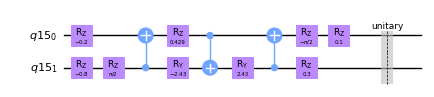

In [ ]:
q = qk.QuantumRegister(2)
smallcirc = qk.QuantumCircuit(q)
gate_params = np.array([-0.2,-0.8,1.,2.,0.1,0.3])
u1gate(smallcirc,gate_params,q[0],q[1])

smallcirc.save_unitary()

# Transpile for simulator
simulator = qk.Aer.get_backend('aer_simulator')
circ = qk.transpile(smallcirc, simulator)

# Run and get unitary
result = simulator.run(smallcirc).result()
unitary = result.get_unitary(smallcirc).data
print("Circuit unitary:\n", unitary.round(3))
smallcirc.draw(output='mpl',scale=0.5)

In [116]:
L=6; initial_charge=L/2
initial_state = np.random.choice([0, 1], size=(L,), p=[(L-initial_charge)/L, initial_charge/L])
length=6; weight=4
import random
print(random.sample(range(length), weight))

[3, 0, 4, 5]


In [ ]:
def weak_measurement(circ,q,q_a,theta):
    """
    circ: quantum circuit
    q: the systen qubit to be measured
    q_a: ancilla qubit
    theta: strength of measurement; theta=\pi/2 is projective measurement; \theta -> 0 no measurement
    To implement exp{-i*theta/2 [1-Z_q]X_qa} = exp{-i*theta X_qa/2} exp{i*theta/2 Z_q*X_qa}
    """
    # Doing exp{-i*theta X_qa/2}
    circ.rx(theta,q_a)
    ##### Doing exp{i*theta/2 Z_q*X_qa} ########
    circ.h(q_a) # Rotating X_qa to Z_qa
    # apply exp{i*theta/2 Z_q*Z_qa}
    circ.cnot(q,q_a)
    circ.rz(-theta,q_a)
    circ.cnot(q,q_a)
    circ.h(q_a)
    return circ 

-2.4292036732051034

In [36]:
L = 6 
gamma = 0.07853981633974483 
depth = L//2
import pickle 
import sys
sys.path.insert(1, '/Users/javier/Dropbox/Projects/measurement transitions/learnability_transitions')

with open('qiskit_data/measurement_data_all_qubits_special_depth_ratio=0.5/L={}_depth={}_Q={}_p={}_seed=1.imdat'.format(L,depth,L//2,gamma), 'rb') as f:
    data_raw,_,_ = pickle.load(f)

array_list = []
integer_list = []
for data_sample in data_raw: 
    array_list.append((np.array(data_sample[0][0:depth-1,:])).flatten())
    integer_list.append(data_sample[1])

unique_arrays = []
sum_of_integers = []
array_dict = {}
for arr, val in zip(array_list, integer_list):
    array_key = tuple(arr)
    if array_key not in array_dict:
        array_dict[array_key] = val
    else:
        array_dict[array_key] += val
for key, val in array_dict.items():
    unique_arrays.append(list(key))
    sum_of_integers.append(val)

print(len(unique_arrays))
print(sum_of_integers, len(sum_of_integers), np.sum(sum_of_integers))    
print(len(unique_arrays), unique_arrays)
unique_arrays_reshaped = []
for sample in unique_arrays:
    unique_arrays_reshaped.append(np.reshape(sample, (2,6)))
print(unique_arrays_reshaped)   

a = np.array([[-1., -1., -1., -1.,  1., -1.],
       [-1., -1., -1., -1., -1., -1.]])
for sample in unique_arrays_reshaped:
    if np.array_equal(sample,a):
        print("hey")

18
[49, 40, 10, 13, 1, 45, 1, 41, 56, 22, 46, 31, 3, 9636, 3, 1, 1, 1] 18 10000
18 [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0], [-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0], [-1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0], [-1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0], [1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 